In [58]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import sklearn

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table

## Initial EDA

In [59]:
clickstream_df = pd.read_csv('data/feature_clickstream.csv')
attributes_df = pd.read_csv('data/features_attributes.csv')
financials_df = pd.read_csv('data/features_financials.csv')
loan_df = pd.read_csv('data/lms_loan_daily.csv')

In [60]:
print(clickstream_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215376 entries, 0 to 215375
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   fe_1           215376 non-null  int64 
 1   fe_2           215376 non-null  int64 
 2   fe_3           215376 non-null  int64 
 3   fe_4           215376 non-null  int64 
 4   fe_5           215376 non-null  int64 
 5   fe_6           215376 non-null  int64 
 6   fe_7           215376 non-null  int64 
 7   fe_8           215376 non-null  int64 
 8   fe_9           215376 non-null  int64 
 9   fe_10          215376 non-null  int64 
 10  fe_11          215376 non-null  int64 
 11  fe_12          215376 non-null  int64 
 12  fe_13          215376 non-null  int64 
 13  fe_14          215376 non-null  int64 
 14  fe_15          215376 non-null  int64 
 15  fe_16          215376 non-null  int64 
 16  fe_17          215376 non-null  int64 
 17  fe_18          215376 non-null  int64 
 18  fe_1

In [61]:
print("clickstream outline:")
print("---------------------------------------------------------------------")
print(clickstream_df.info())

clickstream outline:
---------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215376 entries, 0 to 215375
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   fe_1           215376 non-null  int64 
 1   fe_2           215376 non-null  int64 
 2   fe_3           215376 non-null  int64 
 3   fe_4           215376 non-null  int64 
 4   fe_5           215376 non-null  int64 
 5   fe_6           215376 non-null  int64 
 6   fe_7           215376 non-null  int64 
 7   fe_8           215376 non-null  int64 
 8   fe_9           215376 non-null  int64 
 9   fe_10          215376 non-null  int64 
 10  fe_11          215376 non-null  int64 
 11  fe_12          215376 non-null  int64 
 12  fe_13          215376 non-null  int64 
 13  fe_14          215376 non-null  int64 
 14  fe_15          215376 non-null  int64 
 15  fe_16          215376 non-null  int64 
 16  f

In [62]:
print("attributes outline:")
print("---------------------------------------------------------------------")
print(attributes_df.info())

attributes outline:
---------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer_ID    12500 non-null  object
 1   Name           12500 non-null  object
 2   Age            12500 non-null  object
 3   SSN            12500 non-null  object
 4   Occupation     12500 non-null  object
 5   snapshot_date  12500 non-null  object
dtypes: object(6)
memory usage: 586.1+ KB
None


In [63]:
print("financials outline:")
print("---------------------------------------------------------------------")
print(financials_df.info())

financials outline:
---------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               12500 non-null  object 
 1   Annual_Income             12500 non-null  object 
 2   Monthly_Inhand_Salary     12500 non-null  float64
 3   Num_Bank_Accounts         12500 non-null  int64  
 4   Num_Credit_Card           12500 non-null  int64  
 5   Interest_Rate             12500 non-null  int64  
 6   Num_of_Loan               12500 non-null  object 
 7   Type_of_Loan              11074 non-null  object 
 8   Delay_from_due_date       12500 non-null  int64  
 9   Num_of_Delayed_Payment    12500 non-null  object 
 10  Changed_Credit_Limit      12500 non-null  object 
 11  Num_Credit_Inquiries      12500 non-null  float64
 12  Credit_Mix                

In [64]:
print("loan outline:")
print("---------------------------------------------------------------------")
print(loan_df.info())

loan outline:
---------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137500 entries, 0 to 137499
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   loan_id          137500 non-null  object 
 1   Customer_ID      137500 non-null  object 
 2   loan_start_date  137500 non-null  object 
 3   tenure           137500 non-null  int64  
 4   installment_num  137500 non-null  int64  
 5   loan_amt         137500 non-null  int64  
 6   due_amt          137500 non-null  float64
 7   paid_amt         137500 non-null  float64
 8   overdue_amt      137500 non-null  float64
 9   balance          137500 non-null  float64
 10  snapshot_date    137500 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 11.5+ MB
None


In [65]:
# date range check
print("ClickStream Snapshot Date Range")
print(sorted(clickstream_df['snapshot_date'].unique()))

ClickStream Snapshot Date Range
['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01']


In [66]:
# date range check
print("Attributes Snapshot Date Range")
print(sorted(attributes_df['snapshot_date'].unique()))

Attributes Snapshot Date Range
['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01']


In [67]:
# date range check
print("Financials Snapshot Date Range")
print(sorted(financials_df['snapshot_date'].unique()))

Financials Snapshot Date Range
['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01']


In [68]:
# date range check
print("Loan Snapshot Date Range")
print(sorted(loan_df['snapshot_date'].unique()))

Loan Snapshot Date Range
['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01']


## set up pyspark session

In [69]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [70]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
clickstream_end_date_str = "2024-12-01"
attributes_end_date_str = "2025-01-01"
financials_end_date_str = "2025-01-01"
loan_end_date_str = "2025-11-01"

In [71]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

clickstream_dates_str_lst = generate_first_of_month_dates(start_date_str, clickstream_end_date_str)
attributes_dates_str_lst = generate_first_of_month_dates(start_date_str, attributes_end_date_str)
financials_dates_str_lst = generate_first_of_month_dates(start_date_str, financials_end_date_str)
loan_dates_str_lst = generate_first_of_month_dates(start_date_str, loan_end_date_str)

print(clickstream_dates_str_lst)
print(attributes_end_date_str)
print(financials_dates_str_lst)
print(loan_dates_str_lst)

['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01']
2025-01-01
['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01']
['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-

## Build Bronze Table

In [77]:
# create bronze datalake
bronze_loan_directory = "datamart_assignment_1/bronze/loan_lms/"
bronze_clickstream_directory = "datamart_assignment_1/bronze/clickstream/"
bronze_attributes_directory = "datamart_assignment_1/bronze/attributes/"
bronze_financials_directory = "datamart_assignment_1/bronze/financials/"

if not os.path.exists(bronze_loan_directory):
    os.makedirs(bronze_loan_directory)

if not os.path.exists(bronze_clickstream_directory):
    os.makedirs(bronze_clickstream_directory)

if not os.path.exists(bronze_attributes_directory):
    os.makedirs(bronze_attributes_directory)

if not os.path.exists(bronze_financials_directory):
    os.makedirs(bronze_financials_directory)

In [79]:
# csv path
clickstream_path = 'data/feature_clickstream.csv'
attributes_path = 'data/features_attributes.csv'
financials_path = 'data/features_financials.csv'
loan_path = 'data/lms_loan_daily.csv'

In [80]:
# run bronze backfill
for date_str in clickstream_dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_clickstream_directory, spark, clickstream_path, 'clickstream')
for date_str in attributes_dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_attributes_directory, spark, attributes_path, 'attributes')
for date_str in financials_dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_financials_directory, spark, financials_path, 'financials')
for date_str in loan_dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_loan_directory, spark, loan_path, 'loan')

2023-01-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_01_01.csv
2023-02-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_02_01.csv
2023-03-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_03_01.csv
2023-04-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_04_01.csv
2023-05-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_05_01.csv
2023-06-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_06_01.csv
2023-07-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_07_01.csv
2023-08-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_08_01.csv
2023-09-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_09_01.csv
2023-10-01row count: 8974
saved to: datamart_assignment_1/bronze

2024-08-01row count: 543
saved to: datamart_assignment_1/bronze/financials/financials_2024_08_01.csv
2024-09-01row count: 493
saved to: datamart_assignment_1/bronze/financials/financials_2024_09_01.csv
2024-10-01row count: 456
saved to: datamart_assignment_1/bronze/financials/financials_2024_10_01.csv
2024-11-01row count: 488
saved to: datamart_assignment_1/bronze/financials/financials_2024_11_01.csv
2024-12-01row count: 515
saved to: datamart_assignment_1/bronze/financials/financials_2024_12_01.csv
2025-01-01row count: 526
saved to: datamart_assignment_1/bronze/financials/financials_2025_01_01.csv
2023-01-01row count: 530
saved to: datamart_assignment_1/bronze/loan_lms/loan_2023_01_01.csv
2023-02-01row count: 1031
saved to: datamart_assignment_1/bronze/loan_lms/loan_2023_02_01.csv
2023-03-01row count: 1537
saved to: datamart_assignment_1/bronze/loan_lms/loan_2023_03_01.csv
2023-04-01row count: 2047
saved to: datamart_assignment_1/bronze/loan_lms/loan_2023_04_01.csv
2023-05-01row count

In [81]:
# inspect output
bronze_loan_df = utils.data_processing_bronze_table.process_bronze_table("2023-01-01", bronze_loan_directory, spark, loan_path, 'loan').toPandas()
bronze_loan_df

2023-01-01row count: 530
saved to: datamart_assignment_1/bronze/loan_lms/loan_2023_01_01.csv


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x1037_2023_01_01,CUS_0x1037,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
1,CUS_0x1069_2023_01_01,CUS_0x1069,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
2,CUS_0x114a_2023_01_01,CUS_0x114a,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
3,CUS_0x1184_2023_01_01,CUS_0x1184,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
4,CUS_0x1297_2023_01_01,CUS_0x1297,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
525,CUS_0xe98_2023_01_01,CUS_0xe98,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
526,CUS_0xea6_2023_01_01,CUS_0xea6,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
527,CUS_0xed3_2023_01_01,CUS_0xed3,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
528,CUS_0xed8_2023_01_01,CUS_0xed8,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01


In [82]:
bronze_loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loan_id          530 non-null    object 
 1   Customer_ID      530 non-null    object 
 2   loan_start_date  530 non-null    object 
 3   tenure           530 non-null    int32  
 4   installment_num  530 non-null    int32  
 5   loan_amt         530 non-null    int32  
 6   due_amt          530 non-null    float64
 7   paid_amt         530 non-null    float64
 8   overdue_amt      530 non-null    float64
 9   balance          530 non-null    float64
 10  snapshot_date    530 non-null    object 
dtypes: float64(4), int32(3), object(4)
memory usage: 39.5+ KB


In [83]:
# inspect output
bronze_clickstream_df = utils.data_processing_bronze_table.process_bronze_table('2023-01-01', bronze_clickstream_directory, spark, clickstream_path, 'clickstream').toPandas()
bronze_clickstream_df

2023-01-01row count: 8974
saved to: datamart_assignment_1/bronze/clickstream/clickstream_2023_01_01.csv


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,63,118,80,121,55,193,111,112,-101,83,...,-16,-81,-126,114,35,85,-73,76,CUS_0x1037,2023-01-01
1,-108,182,123,4,-56,27,25,-6,284,222,...,-14,-96,200,35,130,94,111,75,CUS_0x1069,2023-01-01
2,-13,8,87,166,214,-98,215,152,129,139,...,26,86,171,125,-130,354,17,302,CUS_0x114a,2023-01-01
3,-85,45,200,89,128,54,76,51,61,139,...,172,96,174,163,37,207,180,118,CUS_0x1184,2023-01-01
4,55,120,226,-86,253,97,107,68,103,126,...,76,43,183,159,-26,104,118,184,CUS_0x1297,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,242,54,14,-84,86,-6,29,22,-6,52,...,197,58,71,61,-141,243,133,77,CUS_0xdf6,2023-01-01
8970,155,200,71,-79,221,223,74,-10,124,211,...,-12,155,10,24,178,49,156,-153,CUS_0xe23,2023-01-01
8971,143,2,42,248,163,-13,-13,20,183,183,...,202,64,105,289,51,77,-20,89,CUS_0xe4e,2023-01-01
8972,109,161,161,29,57,122,-61,223,66,0,...,101,125,249,116,138,-8,160,94,CUS_0xedd,2023-01-01


In [84]:
bronze_clickstream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8974 entries, 0 to 8973
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fe_1           8974 non-null   int32 
 1   fe_2           8974 non-null   int32 
 2   fe_3           8974 non-null   int32 
 3   fe_4           8974 non-null   int32 
 4   fe_5           8974 non-null   int32 
 5   fe_6           8974 non-null   int32 
 6   fe_7           8974 non-null   int32 
 7   fe_8           8974 non-null   int32 
 8   fe_9           8974 non-null   int32 
 9   fe_10          8974 non-null   int32 
 10  fe_11          8974 non-null   int32 
 11  fe_12          8974 non-null   int32 
 12  fe_13          8974 non-null   int32 
 13  fe_14          8974 non-null   int32 
 14  fe_15          8974 non-null   int32 
 15  fe_16          8974 non-null   int32 
 16  fe_17          8974 non-null   int32 
 17  fe_18          8974 non-null   int32 
 18  fe_19          8974 non-null

In [85]:
# inspect output
bronze_attributes_df = utils.data_processing_bronze_table.process_bronze_table('2023-01-01', bronze_attributes_directory, spark, attributes_path, 'attributes').toPandas()
bronze_attributes_df

2023-01-01row count: 530
saved to: datamart_assignment_1/bronze/attributes/attributes_2023_01_01.csv


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1037,Matthewm,45,230-22-9583,Accountant,2023-01-01
1,CUS_0x1069,Andreas Cremero,32,761-27-5143,Accountant,2023-01-01
2,CUS_0x114a,Valetkevitchu,43,133-89-5234,Developer,2023-01-01
3,CUS_0x1184,Cohenq,49,963-76-2464,Lawyer,2023-01-01
4,CUS_0x1297,Edwardsz,46,#F%$D@*&8,Manager,2023-01-01
...,...,...,...,...,...,...
525,CUS_0xe98,Thans,39,663-43-9394,Journalist,2023-01-01
526,CUS_0xea6,Daviesd,31,991-58-6499,Lawyer,2023-01-01
527,CUS_0xed3,Manuelo,30,828-88-6721,Developer,2023-01-01
528,CUS_0xed8,Sudip Kar-Guptag,25,542-81-2536,Engineer,2023-01-01


In [86]:
bronze_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer_ID    530 non-null    object
 1   Name           530 non-null    object
 2   Age            530 non-null    object
 3   SSN            530 non-null    object
 4   Occupation     530 non-null    object
 5   snapshot_date  530 non-null    object
dtypes: object(6)
memory usage: 25.0+ KB


In [87]:
# inspect output
bronze_financials_df = utils.data_processing_bronze_table.process_bronze_table('2023-01-01', bronze_financials_directory, spark, financials_path, 'financials').toPandas()
bronze_financials_df

2023-01-01row count: 530
saved to: datamart_assignment_1/bronze/financials/financials_2023_01_01.csv


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x1037,15989.085,1086.423750,5,4,2,4,"Credit-Builder Loan, Auto Loan, Auto Loan, and...",13,15,...,Good,665.82,40.697699,19 Years and 9 Months,No,33.797021,80.46523951443457,Low_spent_Small_value_payments,284.3801148556844,2023-01-01
1,CUS_0x1069,58637.34,4799.445000,4,6,10,119,"Personal Loan, Auto Loan, and Not Specified",9,17,...,Standard,208.8,25.233144,30 Years and 8 Months,Yes,139.885013,165.21061289035896,High_spent_Small_value_payments,434.8488737169301,2023-01-01
2,CUS_0x114a,15305.46,1230.455000,0,7,2,2,"Student Loan, and Home Equity Loan",14,2,...,Good,642.42_,27.525113,15 Years and 9 Months,No,20.301654,64.77848007633177,Low_spent_Small_value_payments,327.96536605522886,2023-01-01
3,CUS_0x1184,19867.475,1396.622917,3,5,11,3,"Student Loan, Mortgage Loan, and Payday Loan",10,9,...,Good,707.29,26.689790,32 Years and 8 Months,No,42.606882,23.460944042729498,!@9#%8,313.5944656613208,2023-01-01
4,CUS_0x1297,57738.06_,4881.505000,9,8,30,9,"Payday Loan, Personal Loan, Payday Loan, Perso...",61,24,...,Bad,3916.47,25.742143,13 Years and 8 Months,Yes,296.284136,53.82117764831425,High_spent_Medium_value_payments,388.04518664772837,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,CUS_0xe98,68392.18,5622.348333,0,5,12,3,"Debt Consolidation Loan, Mortgage Loan, and De...",15,5,...,Good,719.2,31.818272,27 Years and 9 Months,No,21656.000000,474.1934900205666,Low_spent_Small_value_payments,269.63949315822003,2023-01-01
526,CUS_0xea6,42772.49,3664.374167,4,4,2,4,"Personal Loan, Debt Consolidation Loan, Person...",13,10,...,Good,1321.62,28.344988,31 Years and 10 Months,No,140.919684,423.53195239324754,!@9#%8,91.9857799159662,2023-01-01
527,CUS_0xed3,36035.32,2910.943333,9,10,22,-100,"Credit-Builder Loan, Auto Loan, Home Equity Lo...",33,17,...,Standard,2138.6,26.128601,7 Years and 6 Months,NM,79.977841,105.30444189865106,Low_spent_Large_value_payments,262.97533707434013,2023-01-01
528,CUS_0xed8,15847.06,1560.588333,4,4,8,6,"Auto Loan, Payday Loan, Debt Consolidation Loa...",26,11,...,Standard,412.71,35.954572,8 Years and 6 Months,Yes,45.681084,__10000__,Low_spent_Small_value_payments,240.91220539681208,2023-01-01


In [88]:
bronze_financials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               530 non-null    object 
 1   Annual_Income             530 non-null    object 
 2   Monthly_Inhand_Salary     530 non-null    float64
 3   Num_Bank_Accounts         530 non-null    int32  
 4   Num_Credit_Card           530 non-null    int32  
 5   Interest_Rate             530 non-null    int32  
 6   Num_of_Loan               530 non-null    object 
 7   Type_of_Loan              446 non-null    object 
 8   Delay_from_due_date       530 non-null    int32  
 9   Num_of_Delayed_Payment    530 non-null    object 
 10  Changed_Credit_Limit      530 non-null    object 
 11  Num_Credit_Inquiries      530 non-null    float64
 12  Credit_Mix                530 non-null    object 
 13  Outstanding_Debt          530 non-null    object 
 14  Credit_Uti

### Bronze Layer Conclusion

1. clickstream, attributes and financials are all snapshot table, partitioned by date.  
2. for clickstream, the table is clean and well-structured.
3. for attributes and financials, the data type should be redefined and some symbols in text should be dealed.

In [108]:
bronze_attributes_df['Age'].sort_values()

197    -500
256    -500
351    -500
431    -500
324    -500
       ... 
106    6283
515    7459
82     8100
352    8448
232    8547
Name: Age, Length: 530, dtype: object

In [113]:
bronze_attributes_df['Occupation'].sort_values()

0      Accountant
370    Accountant
368    Accountant
362    Accountant
346    Accountant
          ...    
382       _______
501       _______
296       _______
294       _______
302       _______
Name: Occupation, Length: 530, dtype: object

## Build Silver Table

In [92]:
# create silver datalake
silver_loan_directory = "datamart_assignment_1/silver/loan_lms/"
silver_clickstream_directory = "datamart_assignment_1/silver/clickstream/"
silver_attributes_directory = "datamart_assignment_1/silver/attributes/"
silver_financials_directory = "datamart_assignment_1/silver/financials/"

if not os.path.exists(silver_loan_directory):
    os.makedirs(silver_loan_directory)

if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)

if not os.path.exists(silver_attributes_directory):
    os.makedirs(silver_attributes_directory)

if not os.path.exists(silver_financials_directory):
    os.makedirs(silver_financials_directory)

In [93]:
# run silver backfill
for date_str in loan_dates_str_lst:
    utils.data_processing_silver_table.process_loan_silver_table(date_str, bronze_loan_directory, silver_loan_directory, spark)
for date_str in clickstream_dates_str_lst:
    utils.data_processing_silver_table.process_clickstream_silver_table(date_str, bronze_clickstream_directory, silver_clickstream_directory, spark)
for date_str in attributes_dates_str_lst:
    utils.data_processing_silver_table.process_attributes_silver_table(date_str, bronze_attributes_directory, silver_attributes_directory, spark)
for date_str in financials_dates_str_lst:
    utils.data_processing_silver_table.process_financials_silver_table(date_str, bronze_financials_directory, silver_financials_directory, spark)

loaded from: datamart_assignment_1/bronze/loan_lms/loan_2023_01_01.csv row count: 530
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2023_01_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2023_02_01.csv row count: 1031
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2023_02_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2023_03_01.csv row count: 1537
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2023_03_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2023_04_01.csv row count: 2047
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2023_04_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2023_05_01.csv row count: 2568
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2023_05_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2023_06_01.csv row count: 3085
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2023_06_01.parquet
loade

saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_01_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_02_01.csv row count: 5424


saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_02_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_03_01.csv row count: 5425
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_03_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_04_01.csv row count: 5417


saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_04_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_05_01.csv row count: 5391
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_05_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_06_01.csv row count: 5418
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_06_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_07_01.csv row count: 5442
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_07_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_08_01.csv row count: 5531
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_08_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_09_01.csv row count: 5537
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2024_09_01.parquet
loaded from: datamart_assignment_1/bronze/loan_lms/loan_2024_10_01.csv row count: 5502
save

saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_01_01.parquet
loaded from: datamart_assignment_1/bronze/clickstream/clickstream_2024_02_01.csv row count: 8974
saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_02_01.parquet
loaded from: datamart_assignment_1/bronze/clickstream/clickstream_2024_03_01.csv row count: 8974
saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_03_01.parquet
loaded from: datamart_assignment_1/bronze/clickstream/clickstream_2024_04_01.csv row count: 8974
saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_04_01.parquet
loaded from: datamart_assignment_1/bronze/clickstream/clickstream_2024_05_01.csv row count: 8974
saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_05_01.parquet
loaded from: datamart_assignment_1/bronze/clickstream/clickstream_2024_06_01.csv row count: 8974
saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_

saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_12_01.parquet
loaded from: datamart_assignment_1/bronze/attributes/attributes_2023_01_01.csv row count: 530


saved to: datamart_assignment_1/silver/attributes/silver_attributes_2023_01_01.parquet
loaded from: datamart_assignment_1/bronze/attributes/attributes_2023_02_01.csv row count: 501
saved to: datamart_assignment_1/silver/attributes/silver_attributes_2023_02_01.parquet
loaded from: datamart_assignment_1/bronze/attributes/attributes_2023_03_01.csv row count: 506
saved to: datamart_assignment_1/silver/attributes/silver_attributes_2023_03_01.parquet
loaded from: datamart_assignment_1/bronze/attributes/attributes_2023_04_01.csv row count: 510
saved to: datamart_assignment_1/silver/attributes/silver_attributes_2023_04_01.parquet
loaded from: datamart_assignment_1/bronze/attributes/attributes_2023_05_01.csv row count: 521
saved to: datamart_assignment_1/silver/attributes/silver_attributes_2023_05_01.parquet
loaded from: datamart_assignment_1/bronze/attributes/attributes_2023_06_01.csv row count: 517
saved to: datamart_assignment_1/silver/attributes/silver_attributes_2023_06_01.parquet
loaded f

saved to: datamart_assignment_1/silver/financials/silver_financials_2025_01_01.parquet


In [94]:
#inspect output
silver_loan_df = utils.data_processing_silver_table.process_loan_silver_table("2023-01-01", bronze_loan_directory, silver_loan_directory, spark).toPandas()
silver_loan_df

loaded from: datamart_assignment_1/bronze/loan_lms/loan_2023_01_01.csv row count: 530
saved to: datamart_assignment_1/silver/loan_lms/silver_loan_2023_01_01.parquet


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date,mob,installments_missed,first_missed_date,dpd
0,CUS_0x1037_2023_01_01,CUS_0x1037,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
1,CUS_0x1069_2023_01_01,CUS_0x1069,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
2,CUS_0x114a_2023_01_01,CUS_0x114a,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
3,CUS_0x1184_2023_01_01,CUS_0x1184,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
4,CUS_0x1297_2023_01_01,CUS_0x1297,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,CUS_0xe98_2023_01_01,CUS_0xe98,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
526,CUS_0xea6_2023_01_01,CUS_0xea6,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
527,CUS_0xed3_2023_01_01,CUS_0xed3,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0
528,CUS_0xed8_2023_01_01,CUS_0xed8,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0


In [95]:
silver_loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_id              530 non-null    object 
 1   Customer_ID          530 non-null    object 
 2   loan_start_date      530 non-null    object 
 3   tenure               530 non-null    int32  
 4   installment_num      530 non-null    int32  
 5   loan_amt             530 non-null    float32
 6   due_amt              530 non-null    float32
 7   paid_amt             530 non-null    float32
 8   overdue_amt          530 non-null    float32
 9   balance              530 non-null    float32
 10  snapshot_date        530 non-null    object 
 11  mob                  530 non-null    int32  
 12  installments_missed  530 non-null    int32  
 13  first_missed_date    0 non-null      object 
 14  dpd                  530 non-null    int32  
dtypes: float32(5), int32(5), object(5)
memor

In [96]:
# run silver backfill to process loan data
silver_clickstream_df = utils.data_processing_silver_table.process_clickstream_silver_table("2023-01-01", bronze_clickstream_directory, silver_clickstream_directory, spark).toPandas()
silver_clickstream_df

loaded from: datamart_assignment_1/bronze/clickstream/clickstream_2023_01_01.csv row count: 8974
saved to: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_01_01.parquet


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,63,118,80,121,55,193,111,112,-101,83,...,-16,-81,-126,114,35,85,-73,76,CUS_0x1037,2023-01-01
1,-108,182,123,4,-56,27,25,-6,284,222,...,-14,-96,200,35,130,94,111,75,CUS_0x1069,2023-01-01
2,-13,8,87,166,214,-98,215,152,129,139,...,26,86,171,125,-130,354,17,302,CUS_0x114a,2023-01-01
3,-85,45,200,89,128,54,76,51,61,139,...,172,96,174,163,37,207,180,118,CUS_0x1184,2023-01-01
4,55,120,226,-86,253,97,107,68,103,126,...,76,43,183,159,-26,104,118,184,CUS_0x1297,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,242,54,14,-84,86,-6,29,22,-6,52,...,197,58,71,61,-141,243,133,77,CUS_0xdf6,2023-01-01
8970,155,200,71,-79,221,223,74,-10,124,211,...,-12,155,10,24,178,49,156,-153,CUS_0xe23,2023-01-01
8971,143,2,42,248,163,-13,-13,20,183,183,...,202,64,105,289,51,77,-20,89,CUS_0xe4e,2023-01-01
8972,109,161,161,29,57,122,-61,223,66,0,...,101,125,249,116,138,-8,160,94,CUS_0xedd,2023-01-01


In [97]:
silver_clickstream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8974 entries, 0 to 8973
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fe_1           8974 non-null   int32 
 1   fe_2           8974 non-null   int32 
 2   fe_3           8974 non-null   int32 
 3   fe_4           8974 non-null   int32 
 4   fe_5           8974 non-null   int32 
 5   fe_6           8974 non-null   int32 
 6   fe_7           8974 non-null   int32 
 7   fe_8           8974 non-null   int32 
 8   fe_9           8974 non-null   int32 
 9   fe_10          8974 non-null   int32 
 10  fe_11          8974 non-null   int32 
 11  fe_12          8974 non-null   int32 
 12  fe_13          8974 non-null   int32 
 13  fe_14          8974 non-null   int32 
 14  fe_15          8974 non-null   int32 
 15  fe_16          8974 non-null   int32 
 16  fe_17          8974 non-null   int32 
 17  fe_18          8974 non-null   int32 
 18  fe_19          8974 non-null

In [98]:
# run silver backfill to process loan data
silver_attributes_df = utils.data_processing_silver_table.process_attributes_silver_table('2023-01-01', bronze_attributes_directory, silver_attributes_directory, spark).toPandas()
silver_attributes_df

loaded from: datamart_assignment_1/bronze/attributes/attributes_2023_01_01.csv row count: 530
saved to: datamart_assignment_1/silver/attributes/silver_attributes_2023_01_01.parquet


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1037,Matthewm,45,230-22-9583,Accountant,2023-01-01
1,CUS_0x1069,Andreas Cremero,32,761-27-5143,Accountant,2023-01-01
2,CUS_0x114a,Valetkevitchu,43,133-89-5234,Developer,2023-01-01
3,CUS_0x1184,Cohenq,49,963-76-2464,Lawyer,2023-01-01
4,CUS_0x1297,Edwardsz,46,None,Manager,2023-01-01
...,...,...,...,...,...,...
525,CUS_0xe98,Thans,39,663-43-9394,Journalist,2023-01-01
526,CUS_0xea6,Daviesd,31,991-58-6499,Lawyer,2023-01-01
527,CUS_0xed3,Manuelo,30,828-88-6721,Developer,2023-01-01
528,CUS_0xed8,Sudip Kar,25,542-81-2536,Engineer,2023-01-01


In [99]:
silver_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer_ID    530 non-null    object
 1   Name           530 non-null    object
 2   Age            530 non-null    int32 
 3   SSN            495 non-null    object
 4   Occupation     492 non-null    object
 5   snapshot_date  530 non-null    object
dtypes: int32(1), object(5)
memory usage: 22.9+ KB


In [100]:
silver_financials_df = utils.data_processing_silver_table.process_financials_silver_table(date_str, bronze_financials_directory, silver_financials_directory, spark).toPandas()
silver_financials_df

loaded from: datamart_assignment_1/bronze/financials/financials_2025_01_01.csv row count: 526
saved to: datamart_assignment_1/silver/financials/silver_financials_2025_01_01.parquet


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date,Credit_History_Year,Credit_History_Month
0,CUS_0x1009,5.231268e+04,4250.390137,6,5,17.0,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,40.286995,31 Years and 0 Months,Yes,108.366470,58.660191,High_spent_Medium_value_payments,508.012329,2025-01-01,31,0
1,CUS_0x1098,2.065298e+04,1468.081665,7,5,21.0,2,"Auto Loan, and Payday Loan",24,10,...,37.441101,18 Years and 11 Months,NM,33.238358,54.603386,Low_spent_Small_value_payments,348.966431,2025-01-01,18,11
2,CUS_0x109f,1.304359e+05,10623.655273,4,846,9.0,2,"Home Equity Loan, and Home Equity Loan",13,1,...,34.784702,29 Years and 11 Months,NM,188.186127,1070.730713,Low_spent_Medium_value_payments,81.141937,2025-01-01,29,11
3,CUS_0x10b6,5.691341e+06,1712.969116,7,3,19.0,3,"Payday Loan, Credit-Builder Loan, and Debt Con...",6,12,...,40.278542,18 Years and 4 Months,No,37.996380,65.372162,High_spent_Small_value_payments,327.928375,2025-01-01,18,4
4,CUS_0x10e2,4.313385e+04,3432.487549,10,10,31.0,7,"Personal Loan, Auto Loan, Not Specified, Home ...",43,24,...,27.115860,10 Years and 9 Months,Yes,151.287262,67.892509,High_spent_Large_value_payments,364.069000,2025-01-01,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,CUS_0xf15,4.565217e+04,3888.347412,8,6,13.0,7,"Mortgage Loan, Payday Loan, Debt Consolidation...",10,10,...,26.846632,10 Years and 11 Months,Yes,160.473297,154.470871,Low_spent_Medium_value_payments,353.890594,2025-01-01,10,11
522,CUS_0xf60,3.441376e+04,2916.813232,6,5,8.0,5,"Home Equity Loan, Home Equity Loan, Home Equit...",23,20,...,24.508003,6 Years and 4 Months,Yes,74.328712,330.763123,Low_spent_Small_value_payments,176.589508,2025-01-01,6,4
523,CUS_0xf74,1.711135e+04,1367.645508,10,6,3868.0,7,"Personal Loan, Mortgage Loan, Home Equity Loan...",55,25,...,25.724680,19 Years and 0 Months,Yes,95.734001,55.600227,Low_spent_Medium_value_payments,264.660645,2025-01-01,19,0
524,CUS_0xf95,1.560456e+04,1389.380005,9,5,25.0,3,"Debt Consolidation Loan, Home Equity Loan, and...",27,23,...,35.184082,19 Years and 10 Months,Yes,37.912350,92.113991,Low_spent_Small_value_payments,298.911652,2025-01-01,19,10


In [101]:
silver_financials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               526 non-null    object 
 1   Annual_Income             526 non-null    float32
 2   Monthly_Inhand_Salary     526 non-null    float32
 3   Num_Bank_Accounts         526 non-null    int32  
 4   Num_Credit_Card           526 non-null    int32  
 5   Interest_Rate             526 non-null    float32
 6   Num_of_Loan               526 non-null    int32  
 7   Type_of_Loan              468 non-null    object 
 8   Delay_from_due_date       526 non-null    int32  
 9   Num_of_Delayed_Payment    526 non-null    int32  
 10  Changed_Credit_Limit      518 non-null    float32
 11  Num_Credit_Inquiries      526 non-null    int32  
 12  Credit_Mix                420 non-null    object 
 13  Outstanding_Debt          526 non-null    float32
 14  Credit_Uti

### Silver Layer Conclusion

All tables are defined with new and correct schema

## EDA on Click Stream

In [118]:
# Path to the folder containing CSV files
folder_path = silver_clickstream_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
clickstream_df = df.toPandas()

#check missing values
print(clickstream_df.shape[0])
clickstream_df.info()

print(len(clickstream_df.groupby(['Customer_ID', 'snapshot_date']).size()))

215376
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215376 entries, 0 to 215375
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   fe_1           215376 non-null  int32 
 1   fe_2           215376 non-null  int32 
 2   fe_3           215376 non-null  int32 
 3   fe_4           215376 non-null  int32 
 4   fe_5           215376 non-null  int32 
 5   fe_6           215376 non-null  int32 
 6   fe_7           215376 non-null  int32 
 7   fe_8           215376 non-null  int32 
 8   fe_9           215376 non-null  int32 
 9   fe_10          215376 non-null  int32 
 10  fe_11          215376 non-null  int32 
 11  fe_12          215376 non-null  int32 
 12  fe_13          215376 non-null  int32 
 13  fe_14          215376 non-null  int32 
 14  fe_15          215376 non-null  int32 
 15  fe_16          215376 non-null  int32 
 16  fe_17          215376 non-null  int32 
 17  fe_18          215376 non-null  int32 
 1

In [119]:
# check statistics
clickstream_df.describe()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,fe_11,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20
count,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000,215376.000000
mean,101.414796,103.096195,104.333709,105.648503,106.996676,103.235922,107.070337,110.718724,114.406354,117.775797,99.615537,99.823680,100.420804,100.025801,99.600383,99.860834,100.129425,100.125139,100.341162,100.046259
std,99.833594,99.930002,100.599865,100.326065,100.693607,100.270388,100.323265,100.243698,100.186139,100.807686,100.335428,100.591175,100.881826,101.070371,101.145906,100.751876,101.298428,102.231587,102.666804,103.589358
min,-378.000000,-356.000000,-399.000000,-307.000000,-343.000000,-321.000000,-368.000000,-361.000000,-328.000000,-317.000000,-375.000000,-344.000000,-355.000000,-394.000000,-351.000000,-342.000000,-329.000000,-344.000000,-401.000000,-354.000000
25%,34.000000,36.000000,36.000000,38.000000,39.000000,36.000000,39.000000,43.000000,47.000000,50.000000,32.000000,32.000000,33.000000,32.000000,31.000000,32.000000,32.000000,31.000000,31.000000,30.000000
50%,102.000000,103.000000,104.000000,106.000000,107.000000,103.000000,107.000000,111.000000,115.000000,118.000000,100.000000,100.000000,101.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
75%,169.000000,171.000000,172.000000,173.000000,175.000000,171.000000,174.000000,179.000000,182.000000,186.000000,167.000000,168.000000,168.000000,168.000000,168.000000,168.000000,169.000000,169.000000,170.000000,170.000000
max,541.000000,560.000000,583.000000,562.000000,570.000000,565.000000,537.000000,573.000000,577.000000,537.000000,613.000000,550.000000,530.000000,583.000000,597.000000,554.000000,516.000000,551.000000,560.000000,547.000000


### ClickStream Summarisation

1. this is a snapshot table partitioned by date
2. no missing values observed
3. no duplicates by customer_ID and snapshot_date

## EDA on Attributes

In [120]:
# Path to the folder containing CSV files
folder_path = silver_attributes_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
attributes_df = df.toPandas()

# check info
attributes_df.info()

# check if there are duplicated customers
len(attributes_df['Customer_ID'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer_ID    12500 non-null  object
 1   Name           12500 non-null  object
 2   Age            12500 non-null  int32 
 3   SSN            11797 non-null  object
 4   Occupation     11620 non-null  object
 5   snapshot_date  12500 non-null  object
dtypes: int32(1), object(5)
memory usage: 537.2+ KB


12500

In [121]:
attributes_df['Occupation'].unique()

array(['Developer', None, 'Teacher', 'Journalist', 'Entrepreneur',
       'Scientist', 'Doctor', 'Writer', 'Mechanic', 'Manager', 'Engineer',
       'Architect', 'Lawyer', 'Accountant', 'Media_Manager', 'Musician'],
      dtype=object)

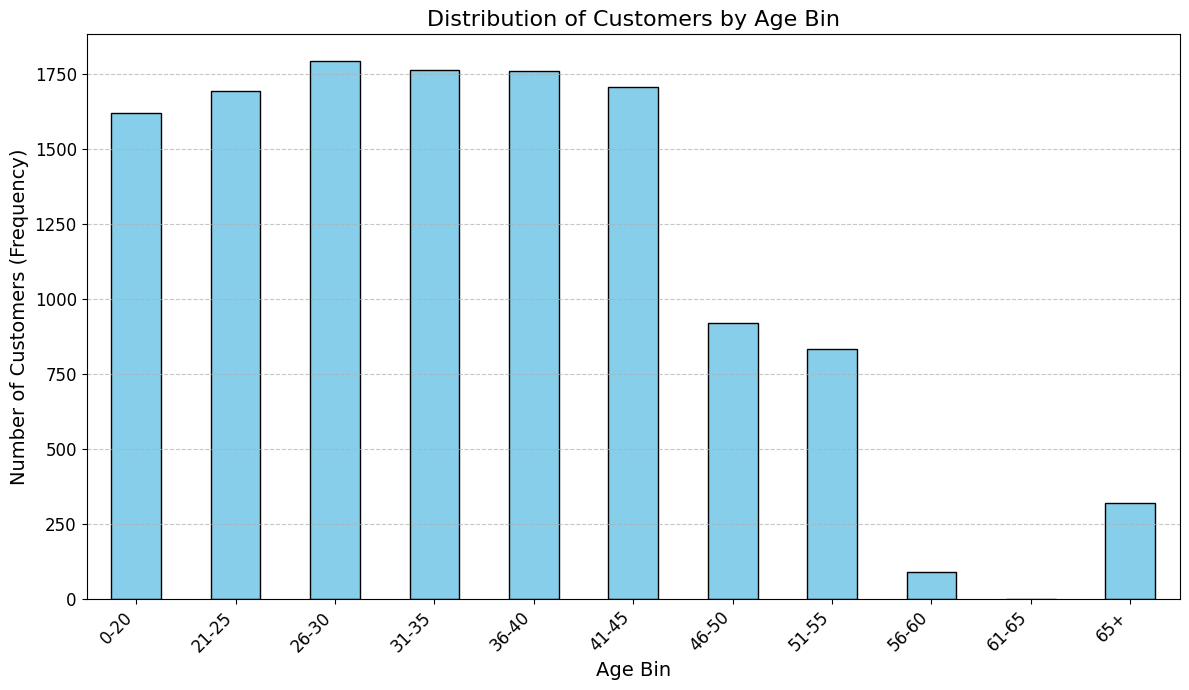

In [122]:
# assuming age over 65 or 70 are outliers, check the proportions
age_bin_edges = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, float('inf')]
age_bin_labels = ['0-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '65+']
attributes_df['age_bin'] = pd.cut(attributes_df['Age'],
                                 bins=age_bin_edges,
                                 labels=age_bin_labels,
                                 include_lowest=True,
                                 right=True)
age_bin_counts = attributes_df['age_bin'].value_counts()
age_bin_counts = age_bin_counts.reindex(age_bin_labels)
plt.figure(figsize=(12, 7))
age_bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Customers by Age Bin', fontsize=16)
plt.xlabel('Age Bin', fontsize=14)
plt.ylabel('Number of Customers (Frequency)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


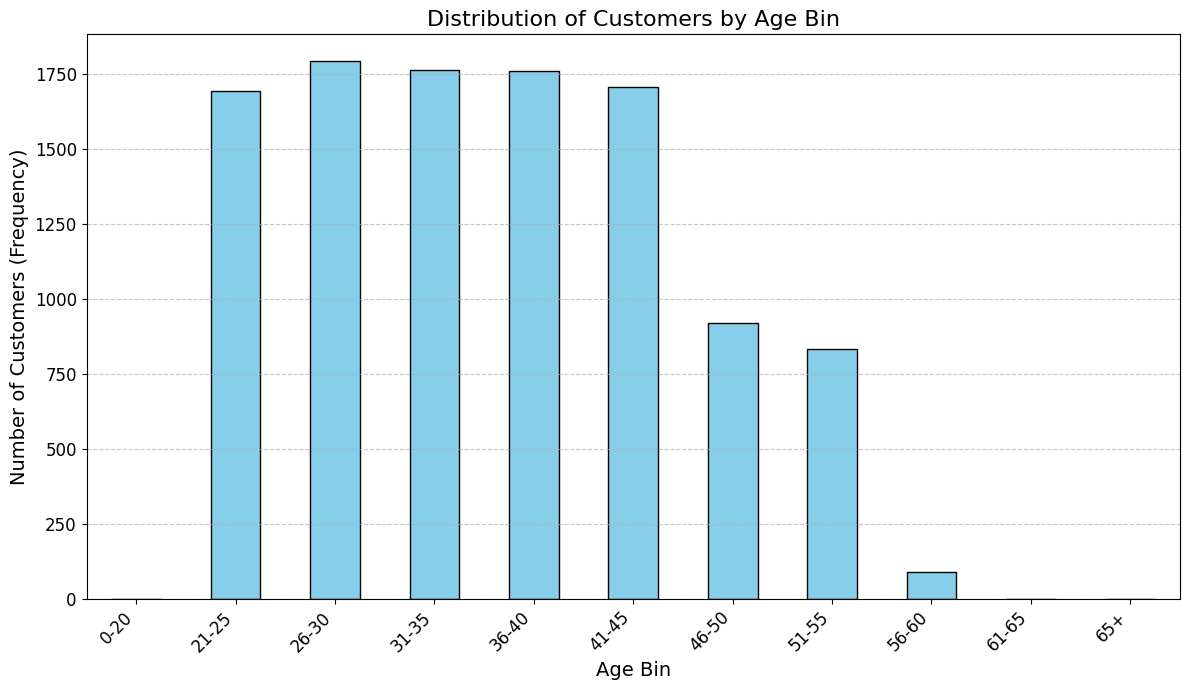

In [123]:
# according to regulartion rules, individuals below 21 are not allowed to borrow loans from financial institutions
# the maximum age for being eligible for DBS personal loan is 70 and UOB personal loan is 65
# age below than 21 and over 65 should be regarded as outliers
# these outliers shoule be replaced marked as NaN 

condition = (attributes_df['Age'] < 21) | (attributes_df['Age'] > 65)
attributes_df['Age'] = np.where(
    condition,
   np.nan, 
    attributes_df['Age']                
) 

age_bin_edges = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, float('inf')]
age_bin_labels = ['0-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '65+']
attributes_df['age_bin'] = pd.cut(attributes_df['Age'],
                                 bins=age_bin_edges,
                                 labels=age_bin_labels,
                                 include_lowest=True,
                                 right=True)

age_bin_counts = attributes_df['age_bin'].value_counts()
age_bin_counts = age_bin_counts.reindex(age_bin_labels)
plt.figure(figsize=(12, 7))
age_bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Customers by Age Bin', fontsize=16)
plt.xlabel('Age Bin', fontsize=14)
plt.ylabel('Number of Customers (Frequency)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

## EDA on Financials

In [130]:
# Path to the folder containing CSV files
folder_path = silver_financials_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
financials_df = df.toPandas()

# check info
financials_df.info()

# check if there are duplicated customers
len(financials_df['Customer_ID'].unique()) # no duplicated users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               12500 non-null  object 
 1   Annual_Income             12500 non-null  float32
 2   Monthly_Inhand_Salary     12500 non-null  float32
 3   Num_Bank_Accounts         12500 non-null  int32  
 4   Num_Credit_Card           12500 non-null  int32  
 5   Interest_Rate             12500 non-null  float32
 6   Num_of_Loan               12500 non-null  int32  
 7   Type_of_Loan              11074 non-null  object 
 8   Delay_from_due_date       12500 non-null  int32  
 9   Num_of_Delayed_Payment    12500 non-null  int32  
 10  Changed_Credit_Limit      12246 non-null  float32
 11  Num_Credit_Inquiries      12500 non-null  int32  
 12  Credit_Mix                9889 non-null   object 
 13  Outstanding_Debt          12500 non-null  float32
 14  Credit

12500

In [131]:
financials_df['Type_of_Loan']

0        Credit-Builder Loan, Credit-Builder Loan, Home...
1                                              Payday Loan
2        Student Loan, Payday Loan, Not Specified, Mort...
3                                                     None
4        Credit-Builder Loan, Home Equity Loan, and Aut...
                               ...                        
12495                                         Student Loan
12496          Not Specified, Auto Loan, and Mortgage Loan
12497    Auto Loan, Personal Loan, Student Loan, Person...
12498    Debt Consolidation Loan, Home Equity Loan, Per...
12499                      Home Equity Loan, and Auto Loan
Name: Type_of_Loan, Length: 12500, dtype: object

In [125]:
split_type_loan = financials_df['Type_of_Loan'].str.split(', ', expand=True)
type_name = [f'Type_of_Loan_{i+1}' for i in range(split_type_loan.shape[1])]
split_type_loan.columns = type_name[:split_type_loan.shape[1]]

stopword = "and "
for i in range(split_type_loan.shape[1]):
    split_type_loan[f"Type_of_Loan_{i+1}"] = split_type_loan[f"Type_of_Loan_{i+1}"].str.removeprefix(stopword)
    
type_set = set()
for i in range(9):
    new = set(split_type_loan[f"Type_of_Loan_{i+1}"].unique())
    type_set.update(new)
type_set.discard(None)
type_set.discard('Not Specified')
type_set

loan_type_columns = [f'Type_of_Loan_{i}' for i in range(1, 10)]
type_list = list(type_set)
output_df = pd.DataFrame(index=split_type_loan.index)
for loan_type in type_list:
    output_df[loan_type] = (split_type_loan[loan_type_columns] == loan_type).any(axis=1).astype(int)


financials_df = pd.concat([financials_df, output_df], axis = 1)
financials_df = financials_df.drop("Type_of_Loan", axis = 1)
financials_df

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_History_Year,Credit_History_Month,Debt Consolidation Loan,Mortgage Loan,Home Equity Loan,Personal Loan,Auto Loan,Credit-Builder Loan,Payday Loan,Student Loan
0,CUS_0x10ac,16718.644531,1270.220459,7,3,15.0,4,26,11,18.450001,...,16,3,1,0,1,0,0,1,0,0
1,CUS_0x10c5,158623.156250,13180.596680,2,7,10.0,1,10,5,6.040000,...,30,2,0,0,0,0,0,0,1,0
2,CUS_0x1145,17975.320312,1444.943359,6,5,32.0,9,61,25,8.900000,...,12,5,0,1,1,0,0,1,1,1
3,CUS_0x11ac,69136.539062,5902.378418,3,4,14.0,0,14,18,7.180000,...,17,5,0,0,0,0,0,0,0,0
4,CUS_0x122c,36346.128906,3188.844238,8,6,11.0,3,21,15,10.540000,...,22,2,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0xd50,43771.851562,3600.654053,4,3,9.0,1,-2,1,3.780000,...,25,9,0,0,0,0,0,0,0,1
12496,CUS_0xde4,75402.523438,6221.543457,2,4,3.0,3,0,5,4.460000,...,28,1,0,1,0,0,1,0,0,0
12497,CUS_0xe16,37976.679688,2997.723389,9,9,18.0,7,56,24,23.070000,...,8,10,0,0,0,1,1,1,0,1
12498,CUS_0xe7a,7711.970215,395.664154,10,5,29.0,7,57,21,30.080000,...,0,11,1,1,1,1,1,0,1,0


In [126]:
# check statistics
financials_df.describe()

# some features have outliers
# Num_Bank_Accounts: nagetive valies
# Delay_from_due_date: nagetive valies

/usr/local/lib/python3.12/site-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)


,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Credit_History_Year,Credit_History_Month,Debt Consolidation Loan,Mortgage Loan,Home Equity Loan,Personal Loan,Auto Loan,Credit-Builder Loan,Payday Loan,Student Loan
count,1.250000e+04,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12246.000000,12500.000000,...,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.00000,12500.000000,12500.000000,12500.000000
mean,1.616205e+05,4188.591797,16.939920,23.172720,73.213364,11.099440,21.060880,33.046400,10.481599,26.695280,...,18.235920,5.777680,0.310400,0.313600,0.314000,0.311040,0.30560,0.317280,0.319440,0.310400
std,1.297842e+06,3180.147705,114.350815,132.005866,468.682220,64.226918,14.863091,238.692938,6.670555,184.193829,...,8.313547,3.451065,0.462676,0.463974,0.464135,0.462938,0.46068,0.465436,0.466278,0.462676
min,7.005930e+03,303.645416,-1.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.030000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.945333e+04,1624.937927,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.380000,4.000000,...,12.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,3.757238e+04,3087.594971,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,9.410000,6.000000,...,18.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,7.269021e+04,5947.364014,7.000000,7.000000,20.000000,6.000000,28.000000,18.000000,14.940000,10.000000,...,25.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
max,2.383470e+07,15204.633789,1756.000000,1499.000000,5789.000000,1495.000000,67.000000,4293.000000,36.970001,2554.000000,...,33.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [128]:
financials_df['Num_Bank_Accounts'].sort_values()

7374       -1
2765       -1
12236      -1
11489      -1
57          0
         ... 
7604     1731
3515     1733
10214    1741
335      1747
765      1756
Name: Num_Bank_Accounts, Length: 12500, dtype: int32

In [48]:
# check outlier proportion of Num_Bank_Accounts and Delay_from_due_date
nba_outlier = financials_df[financials_df['Num_Bank_Accounts'] == -1].shape[0] 
print('Unknown proportion for Num_Bank_Accounts: ', nba_outlier/financials_df.shape[0])


ddd_outlier = financials_df[financials_df['Delay_from_due_date'] == -1].shape[0]
print('Unknown proportion for Delay_from_due_date: ', ddd_outlier/financials_df.shape[0])

Unknown proportion for Num_Bank_Accounts:  0.00032
Unknown proportion for Delay_from_due_date:  0.00248


In [49]:
# replace unknown value by median
condition_nba = financials_df['Num_Bank_Accounts'] < 0
financials_df['Num_Bank_Accounts'] = np.where(
    condition_nba,
   np.nan, 
    financials_df['Num_Bank_Accounts']                
)

condition_ddd = financials_df['Delay_from_due_date'] < 0
financials_df['Delay_from_due_date'] = np.where(
    condition_ddd,
   np.nan, 
    financials_df['Delay_from_due_date']                
)

financials_df.describe()

/usr/local/lib/python3.12/site-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)


,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Credit_History_Year,Credit_History_Month,Debt Consolidation Loan,Personal Loan,Mortgage Loan,Auto Loan,Payday Loan,Credit-Builder Loan,Home Equity Loan,Student Loan
count,1.250000e+04,12500.000000,12496.000000,12500.000000,12500.000000,12500.000000,12412.000000,12500.000000,12246.000000,12500.000000,...,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.00000,12500.000000,12500.000000,12500.000000,12500.000000
mean,1.616205e+05,4188.591797,16.945663,23.172720,73.213364,11.099440,21.226958,33.046400,10.481599,26.695280,...,18.235920,5.777680,0.310400,0.311040,0.313600,0.30560,0.319440,0.317280,0.314000,0.310400
std,1.297842e+06,3180.147705,114.368667,132.005866,468.682220,64.226918,14.783387,238.692938,6.670555,184.193829,...,8.313547,3.451065,0.462676,0.462938,0.463974,0.46068,0.466278,0.465436,0.464135,0.462676
min,7.005930e+03,303.645416,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.030000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.945333e+04,1624.937927,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.380000,4.000000,...,12.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.757238e+04,3087.594971,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,9.410000,6.000000,...,18.000000,5.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,7.269021e+04,5947.364014,7.000000,7.000000,20.000000,6.000000,28.000000,18.000000,14.940000,10.000000,...,25.000000,9.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
max,2.383470e+07,15204.633789,1756.000000,1499.000000,5789.000000,1495.000000,67.000000,4293.000000,36.970001,2554.000000,...,33.000000,11.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [50]:
financials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               12500 non-null  object 
 1   Annual_Income             12500 non-null  float32
 2   Monthly_Inhand_Salary     12500 non-null  float32
 3   Num_Bank_Accounts         12496 non-null  float64
 4   Num_Credit_Card           12500 non-null  int32  
 5   Interest_Rate             12500 non-null  float32
 6   Num_of_Loan               12500 non-null  int32  
 7   Delay_from_due_date       12412 non-null  float64
 8   Num_of_Delayed_Payment    12500 non-null  int32  
 9   Changed_Credit_Limit      12246 non-null  float32
 10  Num_Credit_Inquiries      12500 non-null  int32  
 11  Credit_Mix                9889 non-null   object 
 12  Outstanding_Debt          12500 non-null  float32
 13  Credit_Utilization_Ratio  12500 non-null  float32
 14  Credit

In [51]:
attributes_financials_df = pd.merge(attributes_df, financials_df, on=['Customer_ID', 'snapshot_date'], how='left')
attributes_financials_df

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,age_bin,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_History_Year,Credit_History_Month,Debt Consolidation Loan,Personal Loan,Mortgage Loan,Auto Loan,Payday Loan,Credit-Builder Loan,Home Equity Loan,Student Loan
0,CUS_0x10ac,Zhouy,29.0,780-50-4730,Developer,2024-08-01,26-30,16718.644531,1270.220459,7.0,...,16,3,1,0,0,0,0,1,1,0
1,CUS_0x10c5,Moony,24.0,041-74-6785,None,2024-08-01,21-25,158623.156250,13180.596680,2.0,...,30,2,0,0,0,0,1,0,0,0
2,CUS_0x1145,Blenkinsopr,24.0,426-31-9194,Teacher,2024-08-01,21-25,17975.320312,1444.943359,6.0,...,12,5,0,0,1,0,1,1,1,1
3,CUS_0x11ac,Liana B,26.0,835-92-7751,Journalist,2024-08-01,26-30,69136.539062,5902.378418,3.0,...,17,5,0,0,0,0,0,0,0,0
4,CUS_0x122c,Papadimasf,48.0,883-73-9594,Entrepreneur,2024-08-01,46-50,36346.128906,3188.844238,8.0,...,22,2,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0xdf6,Euan Rochaa,55.0,155-73-3803,Mechanic,2023-09-01,51-55,40453.851562,2772.811035,2.0,...,18,3,0,0,0,0,0,0,0,0
12496,CUS_0xe23,Soyoung Kimg,39.0,825-49-2383,Musician,2023-09-01,36-40,17815.585938,1427.632080,8.0,...,30,11,0,0,0,0,0,0,1,0
12497,CUS_0xe4e,Mirwaisd,22.0,952-71-5963,Scientist,2023-09-01,21-25,108073.679688,8738.139648,3.0,...,19,9,0,0,0,0,0,0,0,0
12498,CUS_0xedd,Lauren Tarao,NaN,888-82-5609,Engineer,2023-09-01,NaN,125468.437500,10445.703125,4.0,...,19,10,0,1,0,0,1,1,0,1


## EDA on credit labels

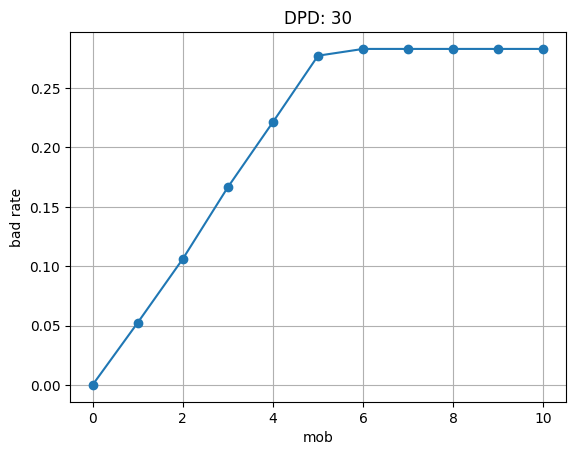

In [52]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_loan_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [53]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

## Build gold table for labels

In [47]:
# create gold datalake
gold_label_store_directory = "datamart_assignment_1/gold/label_store/"
gold_clickstream_store_directory = "datamart_assignment_1/gold/clickstream_store/"
gold_attributes_store_directory = "datamart_assignment_1/gold/attributes_store/"
gold_financials_store_directory = "datamart_assignment_1/gold/financials_store/"
gold_attr_fin_store_directory = "datamart_assignment_1/gold/attr_fin_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

if not os.path.exists(gold_clickstream_store_directory):
    os.makedirs(gold_clickstream_store_directory)

if not os.path.exists(gold_attributes_store_directory):
    os.makedirs(gold_attributes_store_directory)

if not os.path.exists(gold_financials_store_directory):
    os.makedirs(gold_financials_store_directory)

if not os.path.exists(gold_attr_fin_store_directory):
    os.makedirs(gold_attr_fin_store_directory)


In [24]:
# run gold backfill
for date_str in loan_dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)


loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2023_01_01.parquet row count: 530
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2023_02_01.parquet row count: 1031
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2023_03_01.parquet row count: 1537
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2023_04_01.parquet row count: 2047
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2023_05_01.parquet row count: 2568
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2023_06_01.parquet row 

saved to: datamart_assignment_1/gold/label_store/gold_label_store_2024_10_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2024_11_01.parquet row count: 5501


saved to: datamart_assignment_1/gold/label_store/gold_label_store_2024_11_01.parquet


loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2024_12_01.parquet row count: 5531
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2024_12_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2025_01_01.parquet row count: 5539
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2025_01_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2025_02_01.parquet row count: 5028
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2025_02_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2025_03_01.parquet row count: 4515
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2025_03_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2025_04_01.parquet row count: 4024
saved to: datamart_assignment_1/gold/label_store/gold_label_store_2025_04_01.parquet
loaded from: datamart_assignment_1/silver/loan_lms/silver_loan_2025_05_01.parquet row

In [25]:
for date_str in clickstream_dates_str_lst:
    utils.data_processing_gold_table.process_clickstream_gold_table(date_str, silver_clickstream_directory, gold_clickstream_store_directory, spark)

loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_01_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_01_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_02_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_02_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_03_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_03_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_04_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_04_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_05_01.parquet row count: 8974


saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_05_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_06_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_06_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_07_01.parquet row count: 8974


saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_07_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_08_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_08_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_09_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_09_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_10_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_10_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_11_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2023_11_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2023_12_01

saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2024_08_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_09_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2024_09_01.parquet


loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_10_01.parquet row count: 8974


saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2024_10_01.parquet


loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_11_01.parquet row count: 8974


saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2024_11_01.parquet
loaded from: datamart_assignment_1/silver/clickstream/silver_clickstream_2024_12_01.parquet row count: 8974
saved to: datamart_assignment_1/gold/clickstream_store/gold_clickstream_store_2024_12_01.parquet


In [26]:
for date_str in attributes_dates_str_lst:
    utils.data_processing_gold_table.process_attributes_gold_table(date_str, silver_attributes_directory, gold_attributes_store_directory, spark)

loaded from: datamart_assignment_1/silver/attributes/silver_attributes_2023_01_01.parquet row count: 530
saved to: datamart_assignment_1/gold/attributes_store/gold_attributes_store_2023_01_01.parquet
loaded from: datamart_assignment_1/silver/attributes/silver_attributes_2023_02_01.parquet row count: 501
saved to: datamart_assignment_1/gold/attributes_store/gold_attributes_store_2023_02_01.parquet
loaded from: datamart_assignment_1/silver/attributes/silver_attributes_2023_03_01.parquet row count: 506
saved to: datamart_assignment_1/gold/attributes_store/gold_attributes_store_2023_03_01.parquet
loaded from: datamart_assignment_1/silver/attributes/silver_attributes_2023_04_01.parquet row count: 510
saved to: datamart_assignment_1/gold/attributes_store/gold_attributes_store_2023_04_01.parquet
loaded from: datamart_assignment_1/silver/attributes/silver_attributes_2023_05_01.parquet row count: 521
saved to: datamart_assignment_1/gold/attributes_store/gold_attributes_store_2023_05_01.parquet


In [27]:
for date_str in financials_dates_str_lst:
    utils.data_processing_gold_table.process_financials_gold_table(date_str, silver_financials_directory, gold_financials_store_directory, spark)

loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_01_01.parquet row count: 530
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_01_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_02_01.parquet row count: 501
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_02_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_03_01.parquet row count: 506


saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_03_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_04_01.parquet row count: 510


saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_04_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_05_01.parquet row count: 521
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_05_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_06_01.parquet row count: 517
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_06_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_07_01.parquet row count: 471
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_07_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_08_01.parquet row count: 481
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2023_08_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2023_09_01.parquet row count: 454


saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_01_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_02_01.parquet row count: 518
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_02_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_03_01.parquet row count: 511
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_03_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_04_01.parquet row count: 513
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_04_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_05_01.parquet row count: 491


saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_05_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_06_01.parquet row count: 498
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_06_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_07_01.parquet row count: 505
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_07_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_08_01.parquet row count: 543
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_08_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_09_01.parquet row count: 493
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_09_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2024_10_01.parquet row count: 456


saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2024_12_01.parquet
loaded from: datamart_assignment_1/silver/financials/silver_financials_2025_01_01.parquet row count: 526
saved to: datamart_assignment_1/gold/financials_store/gold_financials_store_2025_01_01.parquet


In [28]:
for date_str in financials_dates_str_lst:
    utils.data_processing_gold_table.process_attr_fin_gold_table(date_str, gold_attributes_store_directory, gold_financials_store_directory, gold_attr_fin_store_directory, spark)

saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_01_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_02_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_03_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_04_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_05_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_06_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_07_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_08_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_09_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_10_01.parquet
saved to: datamart_assignment_1/gold/attr_fin_store/gold_attr_fin_store_2023_11_01.parquet

## Inspect Gold stores

In [48]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

print(label_df.show())

row_count: 12500
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    1|30dpd_6mob|   2025-02-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1274_2024_0...| CUS_0x1274|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1288_2024_0...| CUS_0x1288|    1|30dpd_6mob|   2025-02-01|
|CUS_0x12cc_2024_0...| CUS_0x12cc|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1338_2024_0...| CUS_0x1338|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1370_2024_0...| CUS_0x1370|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1378_2024_0...| CUS_0x1378|    1|30dpd_6mob|   2025-02-01|
|CUS_0x139b_2024_0...| CUS_0x139b|    0|30dpd_6mob|   2025-

In [50]:
label_df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)



In [35]:
folder_path = gold_clickstream_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
clickstream_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

clickstream_df.show()

row_count: 12500
+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|
+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| CUS_0x1037|   2024-03-01|  71| 243|  89| 149| 202|  56| 149| 207| 232|  111|  179|  340|  -17|  100|  115|   68|   39|   87|  -74|  240|
| CUS_0x1069|   2024-03-01| -60|  65|  30| -56|  25| 206|  68| 157| -36|   81|   77|   66|  169|   98|   75|  268|   95|   19|  151|  234|
| CUS_0x114a|   2024-03-01|  50|  76| 115| 114| -57| 136|  33|  69| 175|   92|  218|  151|   30|  204|  268|  181|  333|   70|  190|   23|
| CUS_0x1184|   2024-03-01|   1| 245|  72| 247| 212|  80| 144| 138|   7|  -86|  284|   35|  -46|  159|   81|   58|  340|   38|   66|  -36|
| CUS_0x12

In [36]:
clickstream_df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- fe_1: integer (nullable = true)
 |-- fe_2: integer (nullable = true)
 |-- fe_3: integer (nullable = true)
 |-- fe_4: integer (nullable = true)
 |-- fe_5: integer (nullable = true)
 |-- fe_6: integer (nullable = true)
 |-- fe_7: integer (nullable = true)
 |-- fe_8: integer (nullable = true)
 |-- fe_9: integer (nullable = true)
 |-- fe_10: integer (nullable = true)
 |-- fe_11: integer (nullable = true)
 |-- fe_12: integer (nullable = true)
 |-- fe_13: integer (nullable = true)
 |-- fe_14: integer (nullable = true)
 |-- fe_15: integer (nullable = true)
 |-- fe_16: integer (nullable = true)
 |-- fe_17: integer (nullable = true)
 |-- fe_18: integer (nullable = true)
 |-- fe_19: integer (nullable = true)
 |-- fe_20: integer (nullable = true)



In [38]:
folder_path = gold_attributes_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
attributes_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

attributes_df.show()

row_count: 12500
+-----------+-------------+----+------------+
|Customer_ID|snapshot_date| Age|  Occupation|
+-----------+-------------+----+------------+
| CUS_0x10ac|   2024-08-01|29.0|   Developer|
| CUS_0x10c5|   2024-08-01|24.0|        NULL|
| CUS_0x1145|   2024-08-01|24.0|     Teacher|
| CUS_0x11ac|   2024-08-01|26.0|  Journalist|
| CUS_0x122c|   2024-08-01|48.0|Entrepreneur|
| CUS_0x1274|   2024-08-01| NaN|   Scientist|
| CUS_0x1288|   2024-08-01|34.0|      Doctor|
| CUS_0x12cc|   2024-08-01|30.0|   Developer|
| CUS_0x1338|   2024-08-01|40.0|        NULL|
| CUS_0x1370|   2024-08-01|32.0|      Writer|
| CUS_0x1378|   2024-08-01| NaN|    Mechanic|
| CUS_0x139b|   2024-08-01|46.0|   Scientist|
| CUS_0x13a9|   2024-08-01|46.0|     Manager|
| CUS_0x13ce|   2024-08-01|52.0|     Manager|
| CUS_0x147a|   2024-08-01| NaN|      Writer|
| CUS_0x1510|   2024-08-01|27.0|      Doctor|
| CUS_0x1572|   2024-08-01|39.0|    Engineer|
| CUS_0x159b|   2024-08-01|35.0|   Architect|
| CUS_0x15f1|   2

In [40]:
attributes_df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- Age: double (nullable = true)
 |-- Occupation: string (nullable = true)



In [41]:
folder_path = gold_financials_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
financials_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

financials_df.show()

row_count: 12500
+-----------+-------------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+-----------------------------------+-------------------------------+--------------------------+-------------------+--------------------+--------------------+----------+---------------------+--------------------+-----------------------+-------------+-------------+---------+-----------+-------------------+----------------+------------+
|Customer_ID|snapshot_date|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Outstanding_Debt|Credit_Utilization_Ratio|Total_EMI_per_month|Amount_invested_monthly|Monthly_Balance|Debt_to_Inhand_Income_Ratio

In [42]:
financials_df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Monthly_Inhand_Salary: float (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Delay_from_due_date: double (nullable = true)
 |-- Num_of_Delayed_Payment: integer (nullable = true)
 |-- Changed_Credit_Limit: float (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- Credit_Utilization_Ratio: float (nullable = true)
 |-- Total_EMI_per_month: float (nullable = true)
 |-- Amount_invested_monthly: float (nullable = true)
 |-- Monthly_Balance: float (nullable = true)
 |-- Debt_to_Inhand_Income_Ratio_Monthly: double (nullable = true)
 |-- Balance_to_Income_Ratio_Monthly: double (nullable = true)
 |-- Debt_to_Income_Rate_Annual: dou

In [43]:
folder_path = gold_attr_fin_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
attr_fin_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

attr_fin_df.show()

row_count: 12500
+-----------+-------------+----+------------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+-----------------------------------+-------------------------------+--------------------------+-------------------+--------------------+--------------------+----------+---------------------+--------------------+-----------------------+-------------+-------------+---------+-----------+-------------------+----------------+------------+
|Customer_ID|snapshot_date| Age|  Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Outstanding_Debt|Credit_Utilization_Ratio|Total_EMI_per_month|Amount_invested_monthly|Monthly

In [46]:
attr_fin_df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- Age: double (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Monthly_Inhand_Salary: float (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Delay_from_due_date: double (nullable = true)
 |-- Num_of_Delayed_Payment: integer (nullable = true)
 |-- Changed_Credit_Limit: float (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- Credit_Utilization_Ratio: float (nullable = true)
 |-- Total_EMI_per_month: float (nullable = true)
 |-- Amount_invested_monthly: float (nullable = true)
 |-- Monthly_Balance: float (nullable = true)
 |-- Debt_to_Inhand_Income_Ratio_Monthly: double (nullable = true)
 |-- Balance_to_Income